In [193]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import json
import requests
import plotly.express as px
import matplotlib.pyplot as plt
from termcolor import colored                     # coloration du texte
from scipy import stats                           # lois de probabilité (valeurs extrêmes)
from scipy.stats import gumbel_r, genextreme      # valeurs extrêmes
from pyextremes import EVA                        # valeurs extrêmes  
from tabulate import tabulate                     # impression du texte dans un format tabulé
plt.rcParams['text.usetex'] = True                # paramètres latex


plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Times New Roman",
    "font.family": "Linux Libertine",
    "font.size": 12
})
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#plt.style.use('default')

import arviz as az
import pymc as pm
import pymc_experimental.distributions as pmx
import pytensor.tensor as pt
from arviz.plots import plot_utils as azpu
from scipy.optimize import fsolve
import scipy.optimize as optimize

import seaborn as sns
from scipy.stats import expon, norm, chi2
  
import statsmodels.api as sm
################################
## Auteur : Christoophe Ancey ##
## Date : novembre 2024       ##
################################

# Création d'un échantillon de 100 valeurs tirées selon la loi exponentielle

In [176]:
# distribution théorique
distribution_théorique  = expon(loc=0,scale=1)
# Différentes façons de générer un échantillon
# avec numpy
data = np.random.exponential(1, size=100)
# avec scipy
data = distribution_théorique.rvs(size=100)

In [177]:
print(f'Le minimum est {np.min(data):.3f} et le maximum vaut {np.max(data):.2f}')

Le minimum est 0.017 et le maximum vaut 5.45


## Histogramme

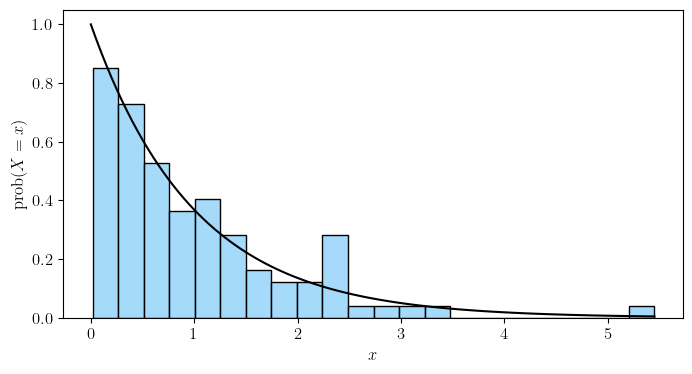

In [178]:
# histogramme + pdf

fig, ax = plt.subplots(figsize=(8,4))
 
# histogramme
sns.histplot(data, ax = ax,  stat = "density", binwidth=0.25, color='lightskyblue'  )
 
plt.xlabel(r'$x$')
plt.ylabel(r'$\mathrm{prob}(X=x)$')

# pdf théorique de la loi de Poisson calée sur les données
 

x = np.arange(0,np.max(data),0.05)
ax.plot(x,  distribution_théorique.pdf(x), color='k',   label='loi exponentielle')

In [179]:
fig.savefig('exemple_exponentielle_pdf.png',dpi=300,bbox_inches='tight')

## Fonction de répartition

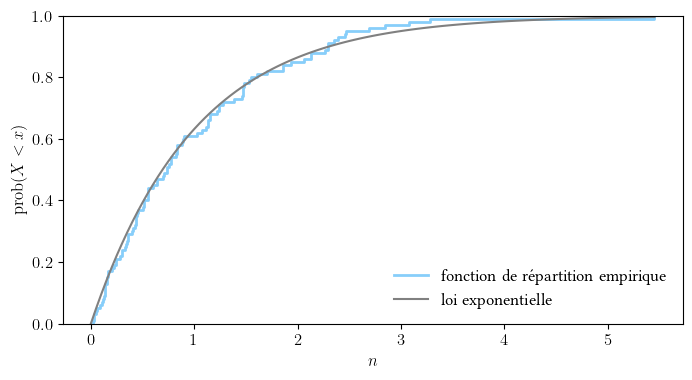

In [180]:
# On trace la fonction de répartition empirique
fig, ax = plt.subplots(figsize=(8,4))

ax.ecdf(data, linewidth = 2, label="fonction de répartition empirique", color='lightskyblue' )


# loi théorique
x = np.arange(0,np.max(data),0.05)
y = distribution_théorique.cdf(x)
ax.plot(x,y,color='grey',label = 'loi exponentielle')

 
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\mathrm{prob}(X< x)$")
ax.legend(loc='lower right',frameon=False)

Text(0.9, 0.8, '(b)')

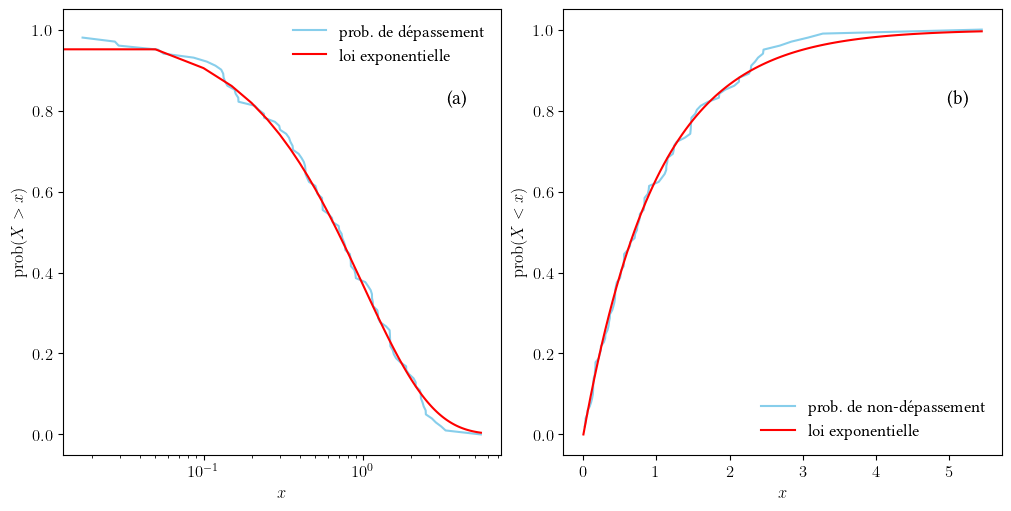

In [181]:
valeurs_triées = np.sort(data )[::-1]
nb_valeurs = len(valeurs_triées)
fréquences_empiriques = [i/(1+nb_valeurs) for i in range(nb_valeurs)]
x = np.arange(0,np.max(data),0.05)
 
fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)

# On trace la fonction de répartition empirique
ax1.semilogx(valeurs_triées,fréquences_empiriques,label='prob. de dépassement', color='skyblue' )
ax1.set_xlabel(r"$x$ ")
ax1.set_ylabel(r"$\mathrm{prob}(X> x)$")


# loi de exponentielle

y = 1- distribution_théorique.cdf(x)
ax1.plot(x,y,  color='red',label = 'loi exponentielle')
ax1.legend(loc='upper right',frameon=False)

##########
# plot 2 #
##########
# On trace la fonction de répartition empirique
ax2.plot(valeurs_triées,1-np.array(fréquences_empiriques),label='prob. de non-dépassement', color='skyblue' )
ax2.set_xlabel(r"$x$  ")
ax2.set_ylabel(r"$\mathrm{prob}(X<x)$")


# loi de exponentielle

y = distribution_théorique.cdf(x)
ax2.plot(x,y,  color='red',label = 'loi exponentielle')
ax2.legend(loc='lower right',frameon=False)

ax1.text(0.9,0.8,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.9,0.8,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)

In [182]:
fig.savefig('exemple_exponentielle.png',dpi=300,bbox_inches='tight')

## Diagrammes PP et QQ

Text(0.1, 0.9, '(b)')

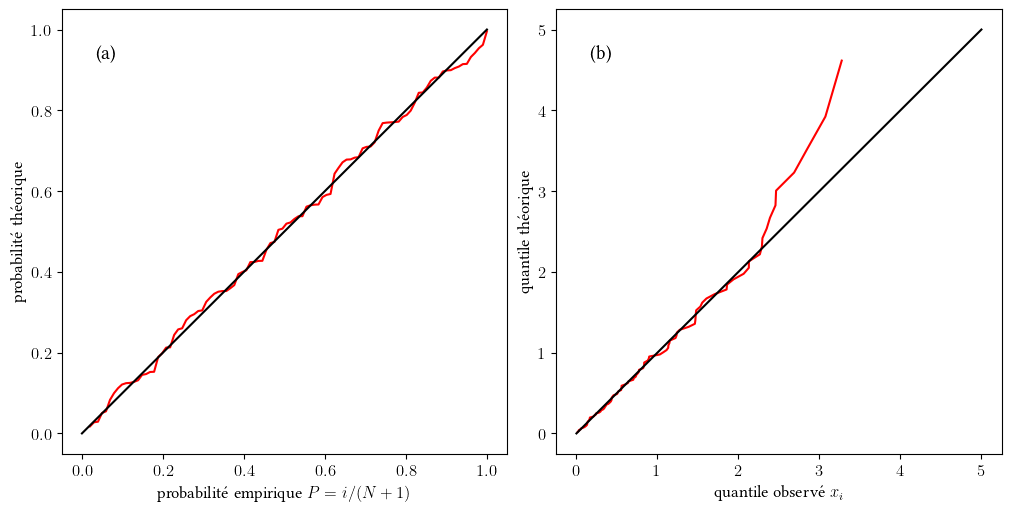

In [183]:
valeurs_triées          = np.sort(data )[::-1]
nb_valeurs              = len(valeurs_triées)
probabilités_empiriques   = [1-i/(1+nb_valeurs) for i in range(nb_valeurs)]
quantiles               = distribution_théorique.ppf(probabilités_empiriques)
probabilités_théoriques = distribution_théorique.cdf(valeurs_triées)

x1 = np.arange(0,1.1,0.1)
x2 = np.arange(0,np.max(data),0.5)
 
fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)

# On trace la fonction de répartition empirique
ax1.plot(probabilités_empiriques,probabilités_théoriques, color='red' )
ax1.set_xlabel(r"probabilité empirique $P=i/(N+1)$ ")
ax1.set_ylabel(r"probabilité théorique")


# bissectrice
y = x1
ax1.plot(x1,y, color='black')
 

##########
# plot 2 #
##########
# On trace la fonction de répartition empirique
ax2.plot(valeurs_triées, quantiles, color='red' )
ax2.set_xlabel(r"quantile observé $x_i$")
ax2.set_ylabel(r"quantile théorique")


# bissectrice
y = x2
ax2.plot(x2,y, color='black')
 

ax1.text(0.1,0.9,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.1,0.9,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)

In [184]:
fig.savefig('exemple_exponentielle_quantile.png',dpi=300,bbox_inches='tight')

## Diagrammes PP et QQ avec la fonction probplot de statsmodels.api

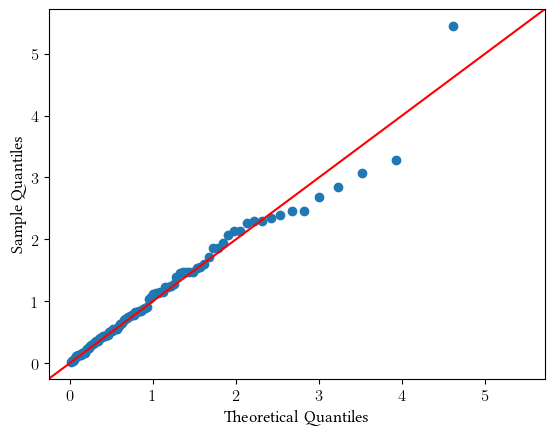

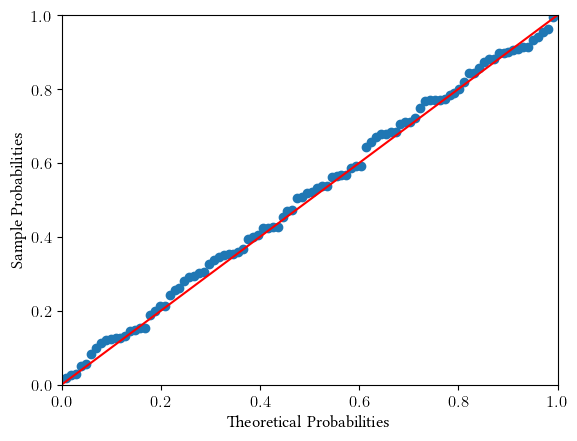

In [187]:
probplot = sm.ProbPlot(np.array(valeurs_triées), stats.expon,  loc=0, scale=1, fit=False)
probplot.qqplot(line="45");
probplot.ppplot(line="45");

Il y a une différence entre la méthode vue en cours et ce que propose cette fonction ProbPlot pour le diagramme QQ, mais la bibliothèque ne précise pas que fait exactement la fonction. D'où l'utilité de parfois programmer ses propres fonctions !

# Log-vraisemblance

In [15]:
def log_vraisemblance(x,lam):
    ddp = lambda z: lam*np.exp(-lam*z)
    logv=np.sum([np.log(ddp(xx)) for xx in x])
    return logv

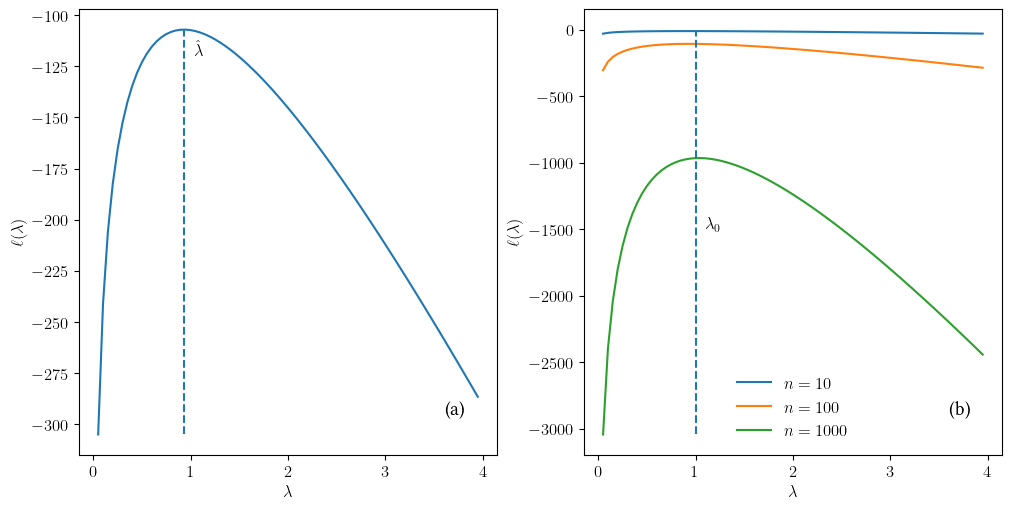

In [46]:
fig, ((ax1, ax2) ) = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5*2)

λ_estimé = 1/np.mean(data)
λ_intervalle = np.arange(0.05,4,0.05)
LV_empirique = [log_vraisemblance(data,l) for l in λ_intervalle]

# plot 1
ax1.plot(λ_intervalle,LV_empirique)
ax1.vlines(λ_estimé,np.min(LV_empirique),np.max(LV_empirique),linestyles='--')
ax1.set_xlabel(r"$\lambda$ ")
ax1.set_ylabel(r"$\ell(\lambda)$")

# plot 2
data_10   = distribution_théorique.rvs(size=10)
data_1000 = distribution_théorique.rvs(size=1000)
λ_10      = 1/np.mean(data_10)
λ_1000    = 1/np.mean(data_1000)
LV_1000   = [log_vraisemblance(data_1000,l) for l in λ_intervalle]
LV_10     = [log_vraisemblance(data_10,l) for l in λ_intervalle]

ax2.plot(λ_intervalle,LV_10,label=r'$n=10$')
ax2.plot(λ_intervalle,LV_empirique,label=r'$n=100$')
ax2.plot(λ_intervalle,LV_1000,label=r'$n=1000$')

ax2.set_xlabel(r"$\lambda$ ")
ax2.set_ylabel(r"$\ell(\lambda)$")
ax2.vlines(1,np.min(LV_1000),0,linestyles='--')

ax1.text(0.9,0.1,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.9,0.1,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)

ax1.text(λ_estimé+0.1,-120,r'$\hat\lambda$')
ax2.text(1.1,-1500,r'$ \lambda_0$')
ax2.legend(frameon=False)

In [47]:
fig.savefig('exemple_exponentielle_logvraisemblance.png',dpi=300,bbox_inches='tight')

In [50]:
print(f'La moyenne est {np.mean(data):0.2f} et donc λ = {λ_estimé:0.2f}')

La moyenne est 1.07 et donc λ = 0.93


## Comportement asymptotique de la log-vraisemblance

Text(0.1, 0.9, '(d)')

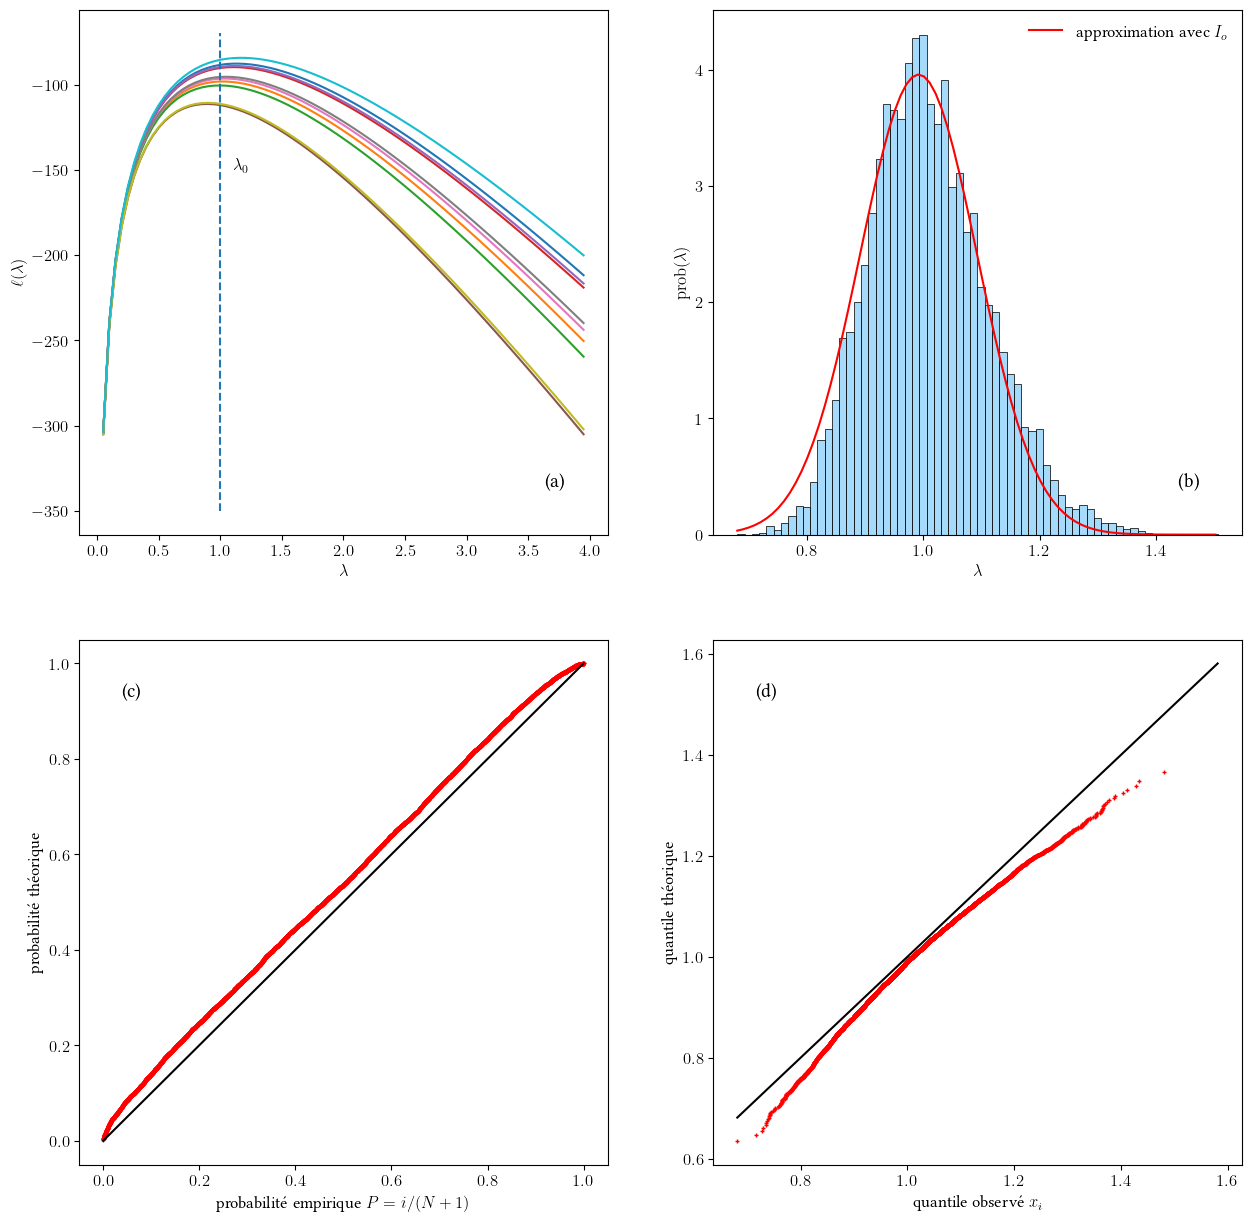

In [191]:


# distribution théorique
distribution_théorique  = expon(loc=0,scale=1)
λ_intervalle = np.arange(0.05,4,0.05)
LV_empirique = [log_vraisemblance(data,l) for l in λ_intervalle]
liste_LV     = []

# on génère des échantillons 
for i in range(10):
    data_100 = distribution_théorique.rvs(size=100)
    λ_100      = 1/np.mean(data_100)
    LV_100   = [log_vraisemblance(data_100,l) for l in λ_intervalle]
    liste_LV.append(LV_100)



liste_LV = np.array(liste_LV)

def information_observée(x,lam):
    n = len(x)
    return -n/lam**2


fig, ((ax1, ax2) ,(ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
##########
# plot 1 #
##########

for lv in liste_LV:
    ax1.plot(λ_intervalle,lv)
ax1.vlines(1,-350,-70,linestyles='--')
ax1.set_xlabel(r"$\lambda$ ")
ax1.set_ylabel(r"$\ell(\lambda)$")

liste_lambda   = []
liste_déviance = []
for i in range(10**4):
    data_100 = distribution_théorique.rvs(size=100)
    λ_estimé = 1/np.mean(data_100)
    liste_lambda.append(λ_estimé)
    liste_déviance.append(2*(log_vraisemblance(data_100,λ_estimé)-log_vraisemblance(data_100,1)))

##########
# plot 2 #
##########
sns.histplot(np.array(liste_lambda).flatten(), ax = ax2,  stat = "density", discrete = False ,color='lightskyblue')
ax2.set_xlabel(r"$\lambda$ ")
ax2.set_ylabel(r"$\mathrm{prob}(\lambda)$")

ax1.text(0.9,0.1,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text(0.9,0.1,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)

ax1.text(1.1,-150,r'$\lambda_0$')

I_o        = information_observée(data_100,liste_lambda[-1])  
écart_type = (-I_o)**-0.5
moyenne    = np.mean(data_100)
axe_x = np.arange(np.min(liste_lambda),np.max(liste_lambda),0.01)
ax2.plot(axe_x, norm.pdf(axe_x, moyenne, écart_type),color='red',label=r'approximation avec $I_o$')
ax2.legend(frameon=False)

distribution_théorique  = stats.norm(loc=moyenne,scale=écart_type )
valeurs_triées          = np.sort(liste_lambda )[::-1]
nb_valeurs              = len(liste_lambda)
probabilités_empiriques = [1-i/(1+nb_valeurs) for i in range(nb_valeurs)]
quantiles               = distribution_théorique.ppf(probabilités_empiriques)
probabilités_théoriques = distribution_théorique.cdf(valeurs_triées)

x1 = np.arange(0,1.1,0.1)
x2 = np.arange(np.min(valeurs_triées),np.max(valeurs_triées)+.1,0.1)
 
##########
# plot 3 #
##########
# On trace la fonction de répartition empirique
ax3.scatter(probabilités_empiriques,probabilités_théoriques, color='red' ,marker='+',linewidths=1,s=10)
ax3.set_xlabel(r"probabilité empirique $P=i/(N+1)$ ")
ax3.set_ylabel(r"probabilité théorique")

# bissectrice
y = x1
ax3.plot(x1,y, color='black')
 

##########
# plot 4 #
##########
# On trace la fonction de répartition empirique
ax4.scatter(valeurs_triées, quantiles, color='red' ,marker='+',linewidths=1,s=10 )
ax4.set_xlabel(r"quantile observé $x_i$")
ax4.set_ylabel(r"quantile théorique")

# bissectrice
y = x2
ax4.plot(x2,y, color='black')
 
ax3.text(0.1,0.9,'(c)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax3.transAxes)
ax4.text(0.1,0.9,'(d)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax4.transAxes)
 


In [192]:
fig.savefig('exemple_logvraisemblance_approx.png',dpi=300,bbox_inches='tight')
# information pour le dernier échantillon
print(f'La moyenne est {np.mean(data):0.2f} et donc Io = {I_o:0.2f}')

La moyenne est 0.99 et donc Io = -98.43


## Déviance

Text(0.05, 0.9, '(a)')

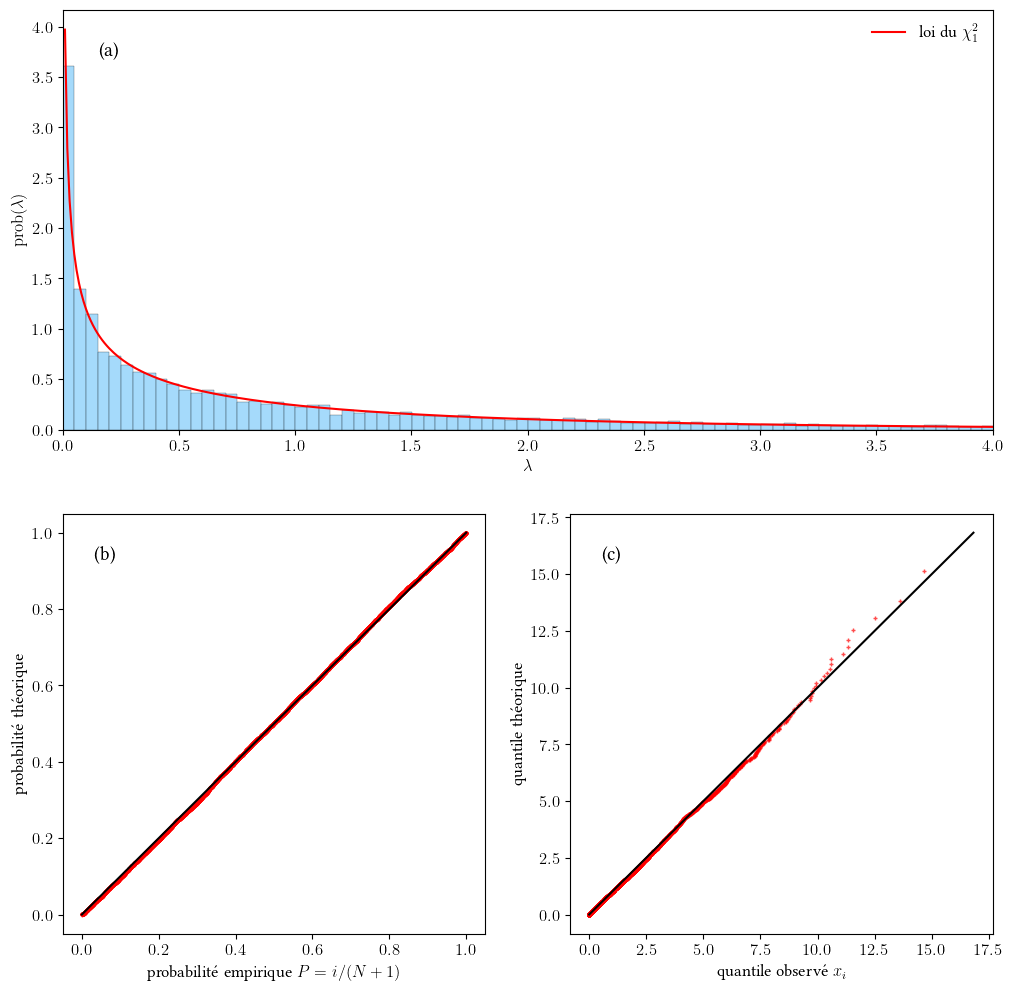

In [209]:
fig = plt.figure(figsize=(12,12))

ax1=plt.subplot(2, 1, 1)
ax2=plt.subplot(2, 2, 3) 
ax3=plt.subplot(2, 2, 4)
 
##########
# plot 1 #
##########

 
sns.histplot(np.array(liste_déviance).flatten(), ax = ax1, binwidth=0.05,  stat = "density", discrete = False ,color='lightskyblue')
ax1.set_xlabel(r"$\lambda$ ")
ax1.set_ylabel(r"$\mathrm{prob}(\lambda)$")
ax1.set_xlim([0,4])


 
axe_x = np.arange(0.01,5,0.01)
ax1.plot(axe_x, chi2.pdf(axe_x, df=1),color='red',label=r'loi du  $\chi^2_1$')
ax1.legend(frameon=False)

distribution_théorique  = stats.chi2(df=1 )
valeurs_triées          = np.sort(liste_déviance )[::-1]
nb_valeurs              = len(liste_déviance)
probabilités_empiriques = [1-i/(1+nb_valeurs) for i in range(nb_valeurs)]
quantiles               = distribution_théorique.ppf(probabilités_empiriques)
probabilités_théoriques = distribution_théorique.cdf(valeurs_triées)

x1 = np.linspace(0,1.0,2)
x2 = np.linspace(0,np.max(valeurs_triées),5)
 
##########
# plot 2 #
##########
# On trace la fonction de répartition empirique
ax2.scatter(probabilités_empiriques,probabilités_théoriques, color='red' ,marker='+',linewidths=1,s=10,alpha=0.7)
ax2.set_xlabel(r"probabilité empirique $P=i/(N+1)$ ")
ax2.set_ylabel(r"probabilité théorique")

# bissectrice
y = x1
ax2.plot(x1,y, color='black')
 

##########
# plot 3 #
##########
# On trace la fonction de répartition empirique
ax3.scatter(valeurs_triées, quantiles, color='red' ,marker='+',linewidths=1,s=10,alpha=0.7 )
ax3.set_xlabel(r"quantile observé $x_i$")
ax3.set_ylabel(r"quantile théorique")

# bissectrice
y = x2
ax3.plot(x2,y, color='black')
 
ax3.text(0.1,0.9,'(c)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax3.transAxes)
ax2.text(0.1,0.9,'(b)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax2.transAxes)
ax1.text(0.05,0.9,'(a)', horizontalalignment='center',fontsize=14,
     verticalalignment='center',
     transform = ax1.transAxes)

In [210]:
fig.savefig('exemple_logvraisemblance_deviance.png',dpi=300,bbox_inches='tight')

# Intervalle de confiance

Text(1.05, -114, '$\\hat\\lambda$')

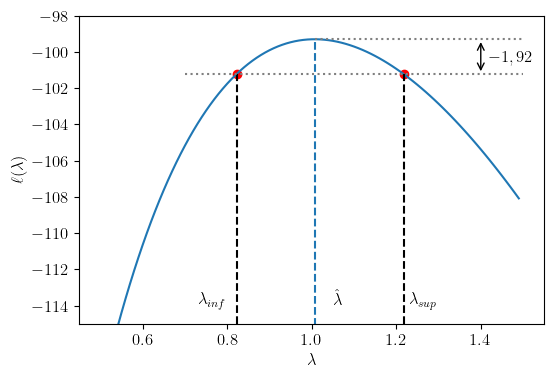

In [245]:
from scipy.optimize import fsolve
def fnc(x):
    lv_max = log_vraisemblance(data,λ_estimé)
    return log_vraisemblance(data,x)-(lv_max-1.92)

l_inf = fsolve(fnc,0.8)[0]
l_sup = fsolve(fnc,1.2)[0]
lv_max = log_vraisemblance(data,λ_estimé)


# plot
fig, ax = plt.subplots(figsize=(6,4))

λ_estimé = 1/np.mean(data)
λ_intervalle = np.arange(0.5,1.5,0.01)
LV_empirique = [log_vraisemblance(data,l) for l in λ_intervalle]


ax.plot(λ_intervalle,LV_empirique)
ax.vlines(λ_estimé,np.min(LV_empirique),np.max(LV_empirique),linestyles='--')
ax.set_xlabel(r"$\lambda$ ")
ax.set_ylabel(r"$\ell(\lambda)$")
ax.set_ylim([-115,-98])
ax.plot([l_sup,l_sup],[-115,lv_max-1.92],color='black',linestyle='--')
ax.plot([l_inf,l_inf],[-115,lv_max-1.92],color='black',linestyle='--')
ax.scatter([l_inf, l_sup], [lv_max-1.92,lv_max-1.92],color='red')
ax.annotate(text='', xy=(1.4, lv_max-1.92), xytext=(1.4, lv_max),
            arrowprops=dict(arrowstyle='<->', color='black'))

ax.plot([λ_estimé,1.5],[lv_max,lv_max ],color='grey',linestyle=':')
ax.plot([0.7,1.5],[lv_max-1.92,lv_max-1.92 ],color='grey',linestyle=':')
ax.text(1.42,lv_max-1.92*2/3,r'$-1,92$')
ax.text(0.73,-114,r'$\lambda_{inf}$')
ax.text(1.23,-114,r'$\lambda_{sup}$')
ax.text(1.05,-114,r'$\hat\lambda$')

In [243]:
fig.savefig('exemple_logvraisemblance_IC.png',dpi=300,bbox_inches='tight')

In [248]:
print(f"Moyenne de l'échantillon  = {1/λ_estimé:.3f}  ")
print(f"Estimation λ = {λ_estimé:.3f} et maximum de log-vraisemblance : {lv_max:0.1f}")
print(f"Intervalle de confiance : λmin = {l_inf:0.3f} et λmax = {l_sup:0.3f} ")
print(f"Information observée : Io= {len(data)/λ_estimé**2 :0.1f} ") 

Moyenne de l'échantillon  = 0.993  
Estimation λ = 1.007 et maximum de log-vraisemblance : -99.3
Intervalle de confiance : λmin = 0.822 et λmax = 1.217 
Information observée : Io= 98.6 
